# Multivariate time series forecasting - LSTM, GRU & TF2


[Yahoo Finance - GE stocks dataset](https://finance.yahoo.com/quote/GE/)

Attributes to be used include:

1. 'Open'
1. 'High'
1. 'Low'
1. 'Close'
1. 'Adj Close'.

- 'Volume' is not being used. _Volume_ is the number of transactions done on that day.

- __Predict 'Open' attribute using all of the above variables__.

- Assumption - these are the right variables affecting the opening price.


- [Reference](https://www.youtube.com/watch?v=tepxdcepTbY)

- [GitHub reference](https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py)

In [39]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.6.0


In [3]:
# Get number of available GPUs-
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"number of GPUs available = {num_gpus}")

number of GPUs available = 0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


In [5]:
# Read in dataset-
data = pd.read_csv("GE_data.csv")

In [6]:
data.shape

(1259, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [8]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
# Convert to DateTime-
data['Date'] = pd.to_datetime(data['Date'])

In [10]:
# Sort in ascending order-
data.sort_values(by = 'Date', ascending = True, inplace = True)

In [11]:
data.reset_index(drop = True, inplace = True)

In [12]:
# Sanity check-
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [13]:
# Check for missing values-
data.isna().values.any()

False

In [14]:
data.isna().sum().sum()

0

### Data Pre-processing:

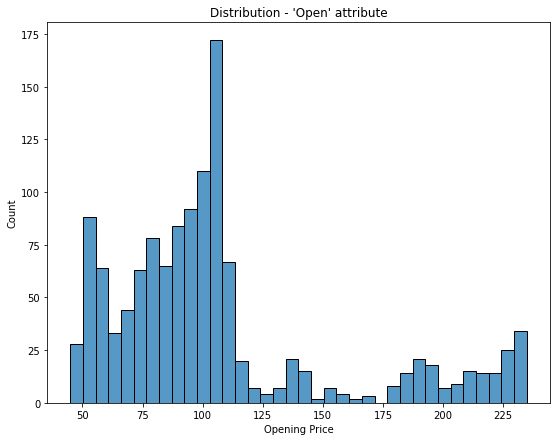

In [15]:
# Visualize distribution of each attribute-
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Open'], bins = int(np.ceil(np.sqrt(len(data)))))
plt.xlabel("Opening Price")
plt.title("Distribution - 'Open' attribute")
plt.show()

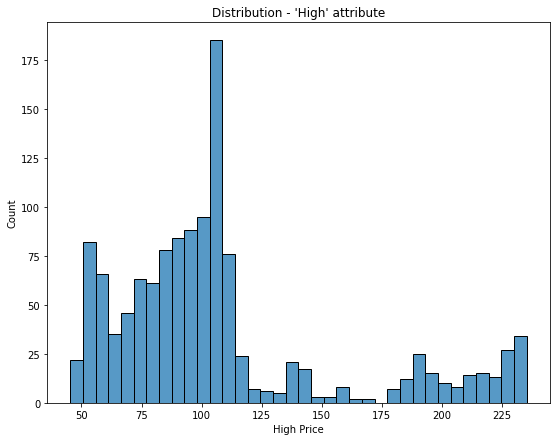

In [16]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['High'], bins = int(np.ceil(np.sqrt(len(data)))))
plt.xlabel("High Price")
plt.title("Distribution - 'High' attribute")
plt.show()

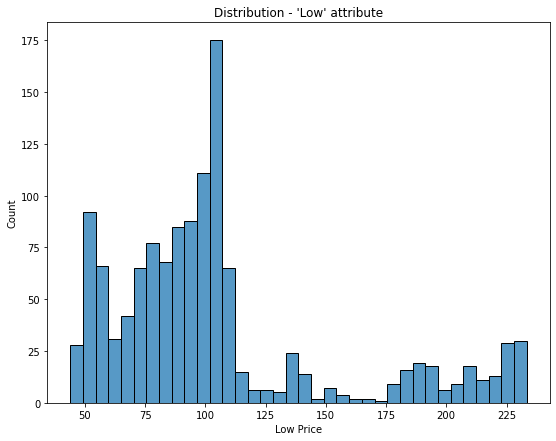

In [17]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Low'], bins = int(np.ceil(np.sqrt(len(data)))))
plt.xlabel("Low Price")
plt.title("Distribution - 'Low' attribute")
plt.show()

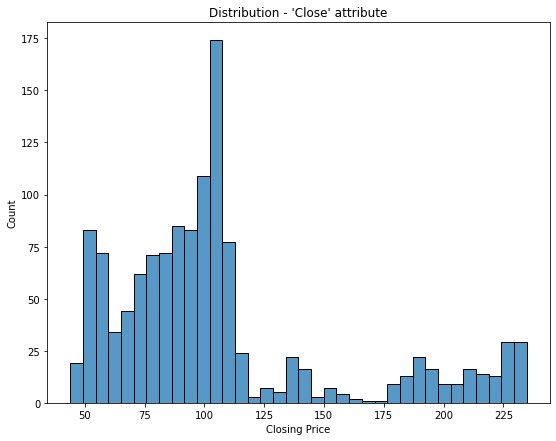

In [18]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Close'], bins = int(np.ceil(np.sqrt(len(data)))))
plt.xlabel("Closing Price")
plt.title("Distribution - 'Close' attribute")
plt.show()

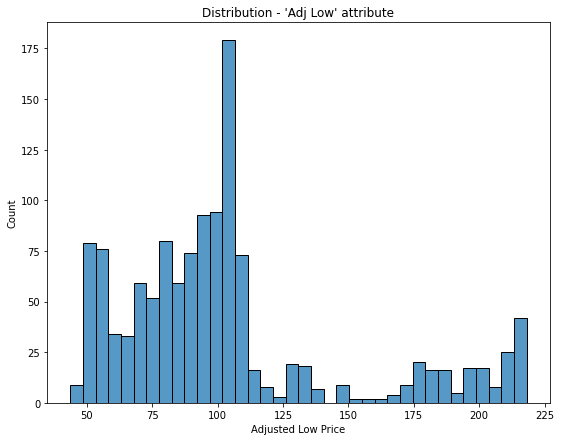

In [19]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Adj Close'], bins = int(np.ceil(np.sqrt(len(data)))))
plt.xlabel("Adjusted Low Price")
plt.title("Distribution - 'Adj Low' attribute")
plt.show()

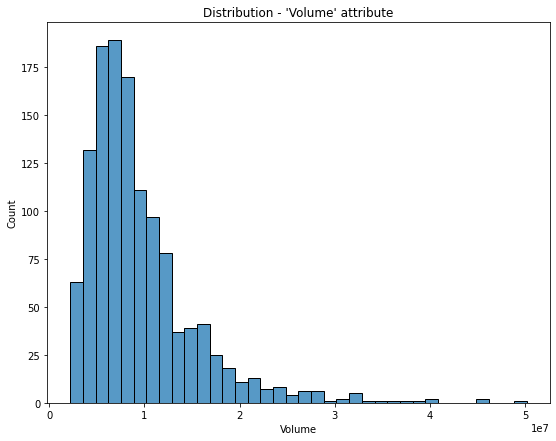

In [20]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Volume'], bins = int(np.ceil(np.sqrt(len(data)))))
plt.xlabel("Volume")
plt.title("Distribution - 'Volume' attribute")
plt.show()

### Observation:

1. Apply some data transformation techniques before applying Standard Sclaer can be used for all attributes/features except _Volume_ which has a skewed distribution.
1. _Volume_ can be attempted to be normalized using - log, inverse, square root, cubic and box-cox transformations

In [27]:
# Apply log transformation-
high_log = np.log(data['High'])

In [28]:
# Apply inverse transformation-
high_inv = 1 / data['High']

In [34]:
# Apply square root transformation-
high_sqrt = np.sqrt(data['High'])

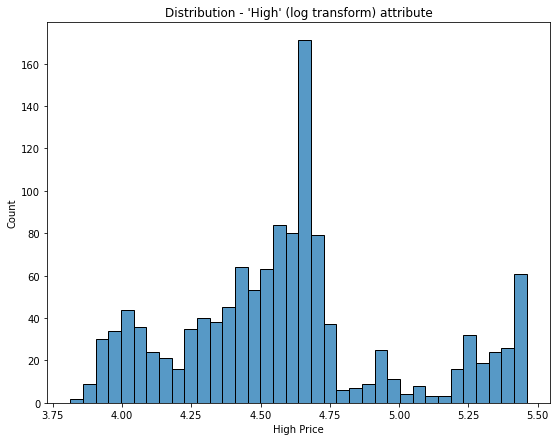

In [26]:
plt.figure(figsize = (9, 7))
sns.histplot(data = high_log, bins = int(np.ceil(np.sqrt((high_log.size)))))
plt.xlabel("High Price")
plt.title("Distribution - 'High' (log transform) attribute")
plt.show()

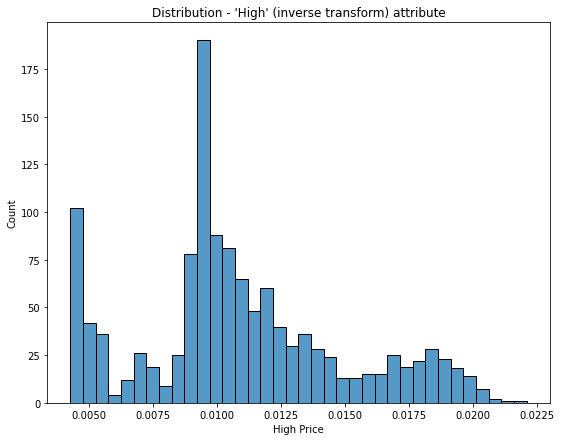

In [31]:
plt.figure(figsize = (9, 7))
sns.histplot(data = high_inv, bins = int(np.ceil(np.sqrt((high_inv.size)))))
plt.xlabel("High Price")
plt.title("Distribution - 'High' (inverse transform) attribute")
plt.show()

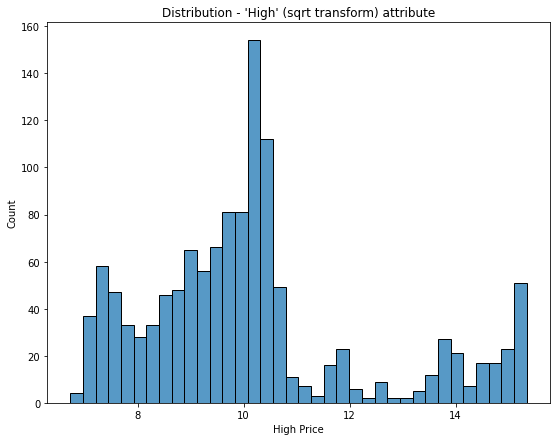

In [35]:
plt.figure(figsize = (9, 7))
sns.histplot(data = high_sqrt, bins = int(np.ceil(np.sqrt((high_sqrt.size)))))
plt.xlabel("High Price")
plt.title("Distribution - 'High' (sqrt transform) attribute")
plt.show()

### Obversvation:

It seems that all of the transformations are almost equal. You might choose betweenn log or inverse transformation.

In [36]:
del high_log, high_inv, high_sqrt

In [15]:
# Print first values-
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-07,228.846161,229.307693,227.153839,227.384613,211.307877,3091179
1,2017-02-08,227.000000,227.230774,225.076920,226.384613,210.378616,4183582
2,2017-02-09,227.076920,228.461533,226.615387,227.615387,211.522354,2816580
3,2017-02-10,228.769226,228.846161,227.307693,228.615387,212.451675,2962323
4,2017-02-13,229.846161,231.230774,228.692307,231.076920,214.739166,4812600
5,2017-02-14,231.769226,232.923080,230.153839,232.923080,216.454773,4553679
6,2017-02-15,233.000000,233.461533,232.153839,233.461533,216.955185,3311399
7,2017-02-16,233.461533,234.384613,233.076920,234.230774,217.670044,3371225
8,2017-02-17,233.923080,234.153839,232.307693,233.615387,217.098175,2840422
9,2017-02-21,233.923080,235.307693,233.384613,234.769226,218.170410,3931330


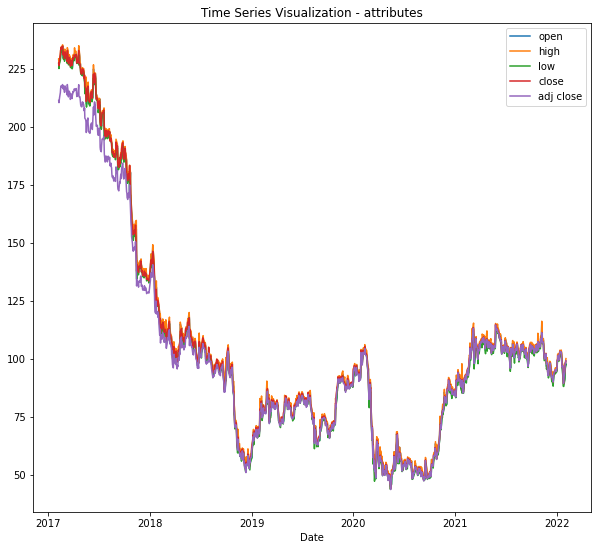

In [16]:
# Visualize time series data-
plt.figure(figsize = (10, 9))
plt.plot(data['Date'], data['Open'], label = 'open')
plt.plot(data['Date'], data['High'], label = 'high')
plt.plot(data['Date'], data['Low'], label = 'low')
plt.plot(data['Date'], data['Close'], label = 'close')
plt.plot(data['Date'], data['Adj Close'], label = 'adj close')
plt.xlabel("Date")
# plt.ylabel("Opening Price")
plt.legend(loc = 'best')
plt.title("Time Series Visualization - attributes")
plt.show() 

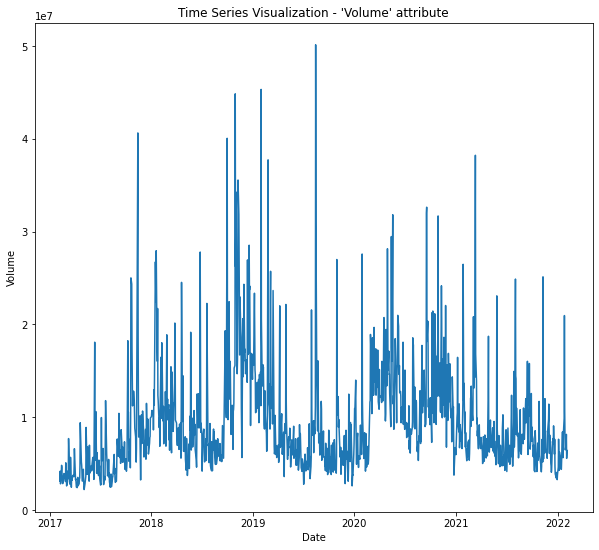

In [17]:
# Visualize time series data-
plt.figure(figsize = (10, 9))
plt.plot(data['Date'], data['Volume'])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Time Series Visualization - 'Volume' attribute")
plt.show() 

In [18]:
# Specify features/channels to be used-
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']

In [19]:
# Create training data-
data_train = data.loc[:, cols].astype(float)

In [20]:
data_train.shape

(1259, 5)

In [21]:
data_train.head()

,Open,High,Low,Close,Adj Close
0,228.846161,229.307693,227.153839,227.384613,211.307877
1,227.000000,227.230774,225.076920,226.384613,210.378616
2,227.076920,228.461533,226.615387,227.615387,211.522354
3,228.769226,228.846161,227.307693,228.615387,212.451675
4,229.846161,231.230774,228.692307,231.076920,214.739166


In [22]:
# Use standard scaler to scale training data-
std_scaler = StandardScaler()
data_train_scaled = std_scaler.fit_transform(data_train)

# LSTM uses sigmoid and tanh activation functionsthat are sensitive to magnitude. Hence, scale them.

In [23]:
type(data_train_scaled), data_train_scaled.shape 

(numpy.ndarray, (1259, 5))

In [24]:
# Sanity check - values after scaling-
for i in range(data_train_scaled.shape[1]):
    print(f"attribute: {i + 1}, min = {data_train_scaled[i].min():.1f} &"
          f" max = {data_train_scaled[i].max():.1f}")

attribute: 1, min = 2.5 & max = 2.6
attribute: 2, min = 2.4 & max = 2.5
attribute: 3, min = 2.5 & max = 2.5
attribute: 4, min = 2.5 & max = 2.6
attribute: 5, min = 2.5 & max = 2.6


### LSTM specific training data reshaping:

- As required for LSTM networks, we require to reshape an input data into: _n_samples x timesteps x n_features_.

- In this example, the _n_features_ is 5. We will make timesteps = 14 (past days data used for training). 

Capture the training series ```X_train``` and prediction ```y_train```. If say your training consists of 10 values then the 11th value is output. You then shift these 10 values by 1 to the RHS and continue - similar to __sliding window protocol__. Note that this does not have to be one, your output can be the 3rd or 4th value (and so on).

We are going to capture this. _The 5 variables are reshaped into chunks along with the value to be predicted_.

- ```n_future``` - how far in the future do you want to predict for (aka _look back_)

- ```n_past``` - how many past values are you using to predict for ```n_future```

Example:

- Use the first 1 to 14 values as input. The 15th value is the value to be predicted.

- Use the values from 2 to 15 as input and predict the 16th value (and so on).

In [25]:
# Python3 lists to be populated using formatted training data-
X_train = []
y_train = []

In [26]:
# Number of days to predict using past days-
n_future = 1

# Number of past days to be used for training & prediction-
n_past = 14

In [ ]:
"""
len(data_train_scaled) - n_future + 1
# 1259

i_l = []

for i in range(n_past, len(data_train_scaled) - n_future + 1):
    i_l.append(i)

len(i_l), len(data_train_scaled)
# (1245, 1259)

i_l[0], i_l[-1]
# (14, 1258)

i, i - n_past
# (1258, 1244)

data_train_scaled.shape
# (1259, 5)

data_train_scaled[0, 0: data_train_scaled.shape[1]].shape
# (5,)

"""

In [27]:
# Reformat input data into the shape: (n_samples x timesteps x n_features)

# In this example, the scaled dataset for training has the shape (1259, 5)
# 1259 refers to the number of data points or examples. And 5 refers to the
# columns or attributes (multi-variables).

for i in range(n_past, len(data_train_scaled) - n_future +1):
    X_train.append(data_train_scaled[i - n_past : i, 0 : data_train_scaled.shape[1]])
    y_train.append(data_train_scaled[i + n_future - 1 : i + n_future, 0])


In [28]:
len(X_train), len(y_train)

(1245, 1245)

In [29]:
X_train[0].shape

(14, 5)

In [30]:
# Convert to np arrays-
X_train, y_train = np.asarray(X_train), np.asarray(y_train)

In [31]:
print(f"X_train.shape: {X_train.shape} & y_train.shape: {y_train.shape}")

X_train.shape: (1245, 14, 5) & y_train.shape: (1245, 1)


### Explanation for reshaped data

```X_train``` = (1245, 14, 5) - the difference between ```data_train_scaled``` & ```X_train``` is due to ```n_past```. ```n_past``` = 14 and we are using 5 features.

In [32]:
len(data_train_scaled) - len(X_train) == n_past

True

### Data Reshaping Explanation:

- Use the first ```n_future``` values as input for all _n_ features (in this example, _n_future = 14_) to predict the ```n_future + 1```th value.

- Shift by 1 value to the RHS similar to _sliding windows protocol_.

In [33]:
data_train_scaled[:n_past + 1, :]

array([[2.551367  , 2.53468985, 2.55230242, 2.52787956, 2.45392725],
       [2.51287861, 2.49137563, 2.50890508, 2.50700033, 2.43277621],
       [2.51448222, 2.51704315, 2.54105144, 2.53269794, 2.45880899],
       [2.54976307, 2.52506459, 2.55551721, 2.55357717, 2.47996139],
       [2.57221479, 2.57479579, 2.5844488 , 2.60497209, 2.53202728],
       [2.61230646, 2.6100889 , 2.6149876 , 2.64351849, 2.57107644],
       [2.63796539, 2.62131835, 2.65677772, 2.65476097, 2.58246639],
       [2.64758734, 2.64056922, 2.67606556, 2.67082213, 2.59873739],
       [2.65720958, 2.63575642, 2.65999251, 2.65797333, 2.585721  ],
       [2.65720958, 2.65982009, 2.68249482, 2.6820646 , 2.61012629],
       [2.67484986, 2.65340314, 2.66963627, 2.65154891, 2.57921211],
       [2.59787341, 2.5780041 , 2.60373662, 2.60176003, 2.56773153],
       [2.56580005, 2.59565083, 2.59248532, 2.62906367, 2.59561267],
       [2.599477  , 2.58923386, 2.61177313, 2.58891122, 2.55461199],
       [2.58985507, 2.5780041 , 2.

In [34]:
X_train[0, :].shape

(14, 5)

In [35]:
X_train[0, :]

array([[2.551367  , 2.53468985, 2.55230242, 2.52787956, 2.45392725],
       [2.51287861, 2.49137563, 2.50890508, 2.50700033, 2.43277621],
       [2.51448222, 2.51704315, 2.54105144, 2.53269794, 2.45880899],
       [2.54976307, 2.52506459, 2.55551721, 2.55357717, 2.47996139],
       [2.57221479, 2.57479579, 2.5844488 , 2.60497209, 2.53202728],
       [2.61230646, 2.6100889 , 2.6149876 , 2.64351849, 2.57107644],
       [2.63796539, 2.62131835, 2.65677772, 2.65476097, 2.58246639],
       [2.64758734, 2.64056922, 2.67606556, 2.67082213, 2.59873739],
       [2.65720958, 2.63575642, 2.65999251, 2.65797333, 2.585721  ],
       [2.65720958, 2.65982009, 2.68249482, 2.6820646 , 2.61012629],
       [2.67484986, 2.65340314, 2.66963627, 2.65154891, 2.57921211],
       [2.59787341, 2.5780041 , 2.60373662, 2.60176003, 2.56773153],
       [2.56580005, 2.59565083, 2.59248532, 2.62906367, 2.59561267],
       [2.599477  , 2.58923386, 2.61177313, 2.58891122, 2.55461199]])

In [36]:
y_train[0]

array([2.58985507])

In [37]:
X_train.shape, y_train.shape

((1245, 14, 5), (1245, 1))

- Think of the input shape (```X_train.shape```) to the LSTM deep learning architecture as 1245 different _X_ values of size (14, 5).

- ```y_train``` is just the value for the day after ```n_past``` values.

### Define LSTM Seq2Seq architecture

In [38]:
def Stacked_LSTM():
    # Function to define stacked LSTM architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        LSTM(
            units = 64, activation = 'relu',
            input_shape = (X_train.shape[1], X_train.shape[2]),
            return_sequences = True
        )
    )
    # return sequence for the next LSTM to process.

    model.add(
        LSTM(
            units = 32, activation = 'relu',
            return_sequences = False
        )
    )

    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y_train.shape[1]
        )
    )

    return model


In [40]:
def Stacked_GRU():
    # Function to define stacked GRU architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        GRU(
            units = 64, activation = 'tanh',
            input_shape = (X_train.shape[1], X_train.shape[2]),
            return_sequences = True, return_state = False
        )
    )
    # return sequence for the next GRU to process.

    model.add(
        GRU(
            units = 32, activation = 'tanh',
            return_sequences = False
        )
    )

    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y_train.shape[1]
        )
    )

    return model


In [41]:
# Instantiate an LSTM instance architecture-
model_lstm = Stacked_LSTM()

In [42]:
# Instantiate a GRU instance architecture-
model_gru = Stacked_GRU()

In [43]:
# Compile defined architecture-
model_lstm.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [49]:
# Compile defined architecture-
model_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [44]:
# Get model summary-
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Get model summary-
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 14, 64)            13632     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Count number of trainable parameters manually-
tot_params_lstm = 0

for layer in model_lstm.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params_lstm += loc_params
    print(f"layer: {layer.shape} has {loc_params} weights")

layer: (5, 256) has 1280 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 256 weights
layer: (64, 128) has 8192 weights
layer: (32, 128) has 4096 weights
layer: (128,) has 128 weights
layer: (32, 1) has 32 weights
layer: (1,) has 1 weights


In [54]:
# Count number of trainable parameters manually-
tot_params_gru = 0

for layer in model_gru.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params_gru += loc_params
    print(f"layer: {layer.shape} has {loc_params} weights")

layer: (5, 192) has 960 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (64, 96) has 6144 weights
layer: (32, 96) has 3072 weights
layer: (2, 96) has 0 weights
layer: (32, 1) has 32 weights
layer: (1,) has 0 weights


In [55]:
print(f"Stacked LSTM architecture has {tot_params_lstm} trainable parameters")

Stacked LSTM architecture has 30369 trainable parameters


In [56]:
print(f"Stacked LSTM architecture has {tot_params_gru} trainable parameters")

Stacked LSTM architecture has 22496 trainable parameters


In [59]:
# Define EarlyStopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 3, verbose = 0,
    mode = 'auto', baseline = None,
    restore_best_weights = True
)


In [48]:
# Train LSTM model-
train_history = model_lstm.fit(
    x = X_train, y = y_train,
    epochs = 10, batch_size = 32,
    validation_split = 0.1, verbose = 1,
    # callbacks = [early_stopping]
)

Epoch 1/10
35/35 [==============================] - 3s 23ms/step - loss: 1.4194 - val_loss: 0.0163
Epoch 2/10
35/35 [==============================] - 0s 8ms/step - loss: 0.4485 - val_loss: 0.0062
Epoch 3/10
35/35 [==============================] - 0s 7ms/step - loss: 0.1056 - val_loss: 0.0052
Epoch 4/10
35/35 [==============================] - 0s 7ms/step - loss: 0.0892 - val_loss: 0.0054
Epoch 5/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0740 - val_loss: 0.0046
Epoch 6/10
35/35 [==============================] - 0s 7ms/step - loss: 0.0657 - val_loss: 0.0071
Epoch 7/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0765 - val_loss: 0.0052
Epoch 8/10
35/35 [==============================] - 0s 7ms/step - loss: 0.0792 - val_loss: 0.0045
Epoch 9/10
35/35 [==============================] - 0s 7ms/step - loss: 0.0704 - val_loss: 0.0041
Epoch 10/10
35/35 [==============================] - 0s 7ms/step - loss: 0.0656 - val_loss: 0.0053


In [57]:
# Train GRU model-
train_history_gru = model_gru.fit(
    x = X_train, y = y_train,
    epochs = 10, batch_size = 32,
    validation_split = 0.1, verbose = 1,
    # callbacks = [early_stopping]
)

Epoch 1/10
35/35 [==============================] - 5s 41ms/step - loss: 0.0882 - val_loss: 0.0014
Epoch 2/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0181 - val_loss: 9.1728e-04
Epoch 3/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0200 - val_loss: 0.0044
Epoch 4/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0204 - val_loss: 0.0017
Epoch 5/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0173 - val_loss: 0.0017
Epoch 6/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0154 - val_loss: 5.7649e-04
Epoch 7/10
35/35 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 5.8226e-04
Epoch 8/10
35/35 [==============================] - 0s 9ms/step - loss: 0.0146 - val_loss: 7.8157e-04
Epoch 9/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0151 - val_loss: 0.0034
Epoch 10/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0163 - val_loss: 0.0019


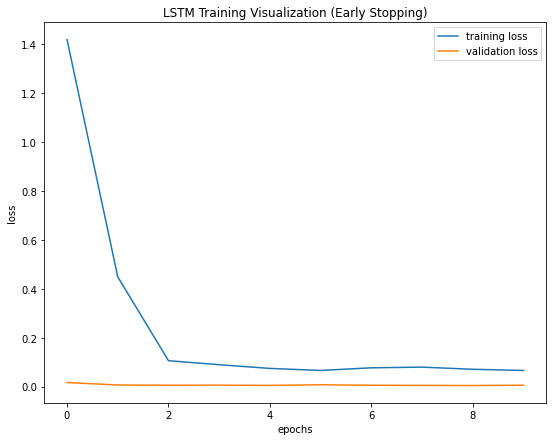

In [58]:
# Visualize LSTM training-
plt.figure(figsize = (9, 7))
plt.plot(train_history.history['loss'], label = 'training loss')
plt.plot(train_history.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM Training Visualization (Early Stopping)")
plt.show()

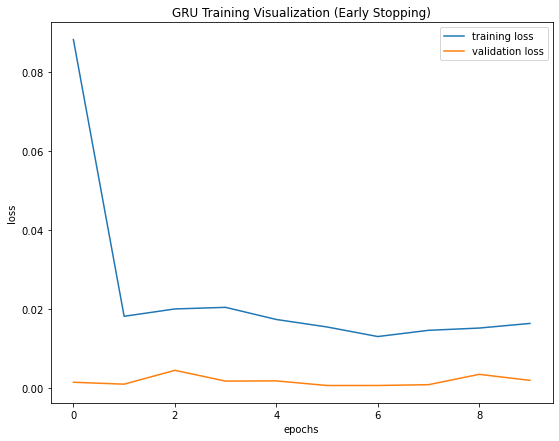

In [59]:
# Visualize LSTM training-
plt.figure(figsize = (9, 7))
plt.plot(train_history_gru.history['loss'], label = 'training loss')
plt.plot(train_history_gru.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("GRU Training Visualization (Early Stopping)")
plt.show()

In [60]:
# Make predictions using trained LSTM model-
y_pred_lstm = model_lstm.predict(X_train)

In [61]:
# Make predictions using trained GRU model-
y_pred_gru = model_gru.predict(X_train)

In [62]:
# Sanity check-
X_train.shape, y_train.shape, y_pred_lstm.shape, y_pred_gru.shape

((1245, 14, 5), (1245, 1), (1245, 1), (1245, 1))

In [67]:
# Compute metrics-
mae_lstm = mean_absolute_error(y_true = y_train, y_pred = y_pred_lstm)
mse_lstm = mean_squared_error(y_true = y_train, y_pred = y_pred_lstm)

mae_gru = mean_absolute_error(y_true = y_train, y_pred = y_pred_gru)
mse_gru = mean_squared_error(y_true = y_train, y_pred = y_pred_gru)

In [68]:
print(f"LSTM: MAE = {mae_lstm:.4f}, MSE = {mse_lstm:.4f} & RMSE = {np.sqrt(mse_lstm):.4f}")

LSTM: MAE = 0.0954, MSE = 0.0143 & RMSE = 0.1197


In [69]:
print(f"GRU: MAE = {mae_gru:.4f}, MSE = {mse_gru:.4f} & RMSE = {np.sqrt(mse_gru):.4f}")

GRU: MAE = 0.0958, MSE = 0.0199 & RMSE = 0.1412


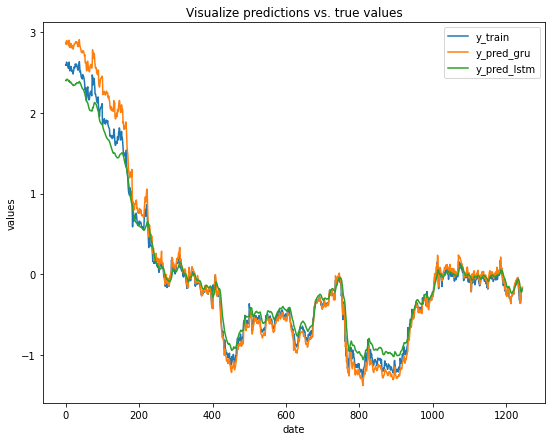

In [71]:
# Visualize predictions vs. true values-
plt.figure(figsize = (9, 7))
plt.plot(y_train, label = 'y_train')
plt.plot(y_pred_gru, label = 'y_pred_gru')
plt.plot(y_pred_lstm, label = 'y_pred_lstm')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

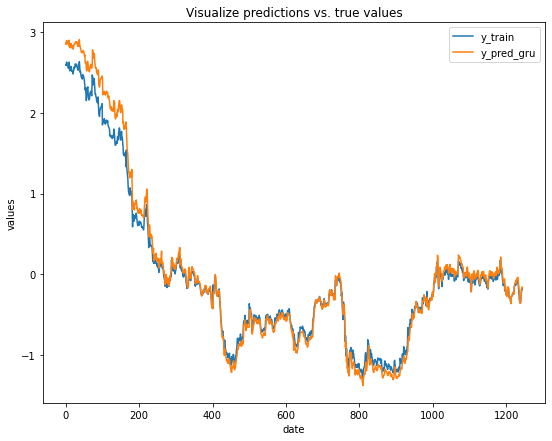

In [72]:
plt.figure(figsize = (9, 7))
plt.plot(y_train, label = 'y_train')
plt.plot(y_pred_gru, label = 'y_pred_gru')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

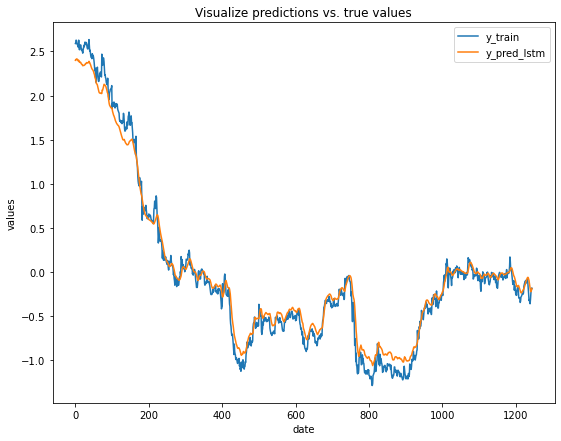

In [73]:
plt.figure(figsize = (9, 7))
plt.plot(y_train, label = 'y_train')
plt.plot(y_pred_lstm, label = 'y_pred_lstm')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

In [ ]:
# Save LSTM trained model for later use-
model_lstm.save_weights("LSTM_Multivariate_GE_stock_prices.h5", overwrite = True)

In [ ]:
# Save GRU trained model for later use-
model_gru.save_weights("GRU_Multivariate_GE_stock_prices.h5", overwrite = True)

In [ ]:
"""
# Instantiate an instance architecture-
model = Stacked_LSTM()

# Load trained weights-
model.load_weights("LSTM_Multivariate_GE_stock_prices.h5")
"""

In [57]:
"""
# Compile defined architecture-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    # optimizer = 'adam',
    loss = tf.keras.losses.MeanSquaredError()
    # loss = 'mse'
)
"""

### Make forecasts

In [ ]:
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay

In [74]:
# Extract dates-
train_dates = data['Date']

In [75]:
# Make forecasts for the next 90 days (3 months)-
n_future = 90

In [76]:
# Extract future dates (for visualizations)-
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods = n_future, freq = '1d').tolist()

# From the last date in 'train_dates' (included) go for the next 89 days.

In [77]:
type(forecast_period_dates), len(forecast_period_dates)

(list, 90)

In [78]:
forecast_period_dates[0], forecast_period_dates[-1]

(Timestamp('2022-02-04 00:00:00', freq='D'),
 Timestamp('2022-05-04 00:00:00', freq='D'))

In [79]:
train_dates.min(), train_dates.max()

(Timestamp('2017-02-07 00:00:00'), Timestamp('2022-02-04 00:00:00'))

In [80]:
X_train[-n_future: ].shape, y_train[-n_future: ].shape

((90, 14, 5), (90, 1))

In [ ]:
# y_train[-n_future: ]

In [81]:
# Make predictions for the future 90 days-
future_predictions_lstm = model_lstm.predict(X_train[-n_future: ])

In [82]:
# Make predictions for the future 90 days-
future_predictions_gru = model_gru.predict(X_train[-n_future: ])

In [83]:
future_predictions_lstm.shape, future_predictions_gru.shape, y_train[-n_future:].shape

((90, 1), (90, 1), (90, 1))

### Reverse scaling:

- Inverse standard scaler to get back predictions in the original data range.

- Since 5 features were used to scaling, inverse scaling expects the same 5 features as inputs.

- Therefore, copy the values 5 times and discard after the inverse scaling operation.

In [84]:
forecast_copies_lstm = np.repeat(future_predictions_lstm, data_train_scaled.shape[1], axis = -1)
forecast_copies_gru = np.repeat(future_predictions_gru, data_train_scaled.shape[1], axis = -1)

In [85]:
forecast_actual = np.repeat(y_train[-n_future: ], data_train_scaled.shape[1], axis = -1)

In [86]:
forecast_copies_lstm.shape, forecast_copies_gru.shape, forecast_actual.shape

((90, 5), (90, 5), (90, 5))

In [87]:
# Sanity check-
forecast_copies_lstm[:5, :]

# The same column is repated 5 times to mimic 5 features

array([[-0.05197221, -0.05197221, -0.05197221, -0.05197221, -0.05197221],
       [-0.03714135, -0.03714135, -0.03714135, -0.03714135, -0.03714135],
       [-0.02837279, -0.02837279, -0.02837279, -0.02837279, -0.02837279],
       [-0.02048305, -0.02048305, -0.02048305, -0.02048305, -0.02048305],
       [-0.01458958, -0.01458958, -0.01458958, -0.01458958, -0.01458958]],
      dtype=float32)

In [88]:
# Sanity check-
forecast_copies_gru[:5, :]

# The same column is repated 5 times to mimic 5 features

array([[ 0.03202664,  0.03202664,  0.03202664,  0.03202664,  0.03202664],
       [ 0.0450796 ,  0.0450796 ,  0.0450796 ,  0.0450796 ,  0.0450796 ],
       [-0.01359798, -0.01359798, -0.01359798, -0.01359798, -0.01359798],
       [ 0.03164097,  0.03164097,  0.03164097,  0.03164097,  0.03164097],
       [ 0.02567231,  0.02567231,  0.02567231,  0.02567231,  0.02567231]],
      dtype=float32)

In [89]:
# Sanity check-
forecast_actual[:5, :]
# The same column is repated 5 times to mimic 5 features

array([[-0.00970491, -0.00970491, -0.00970491, -0.00970491, -0.00970491],
       [-0.00219968, -0.00219968, -0.00219968, -0.00219968, -0.00219968],
       [-0.0476479 , -0.0476479 , -0.0476479 , -0.0476479 , -0.0476479 ],
       [-0.02221354, -0.02221354, -0.02221354, -0.02221354, -0.02221354],
       [-0.02930188, -0.02930188, -0.02930188, -0.02930188, -0.02930188]])

In [93]:
forecast_lstm = std_scaler.inverse_transform(forecast_copies_lstm)[:, 0]

In [90]:
forecast_gru = std_scaler.inverse_transform(forecast_copies_gru)[:, 0]

In [91]:
actual = std_scaler.inverse_transform(forecast_actual)[:, 0]

In [95]:
forecast_lstm.shape, forecast_gru.shape, actual.shape

((90,), (90,), (90,))

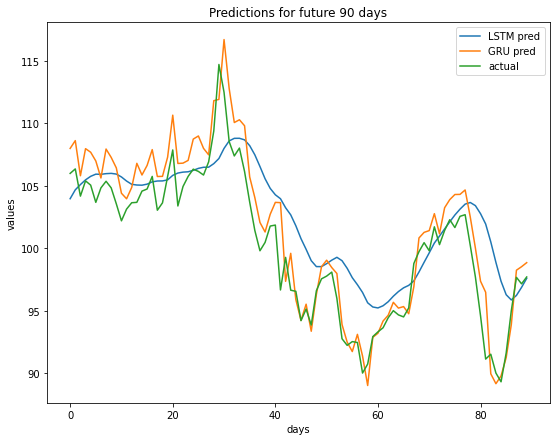

In [96]:
# Visualize predictions for the next 90 days-
plt.figure(figsize = (9, 7))
plt.plot(forecast_lstm, label = 'LSTM pred')
plt.plot(forecast_gru, label = 'GRU pred')
plt.plot(actual, label = 'actual')
plt.xlabel("days")
plt.ylabel("values")
plt.legend(loc = 'best')
plt.title("Predictions for future 90 days")
plt.show()

In [97]:
# Convert pd TimeStamp to Dates-
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [98]:
len(forecast_dates)

90

In [99]:
forecast_dates[:5]

[datetime.date(2022, 2, 4),
 datetime.date(2022, 2, 5),
 datetime.date(2022, 2, 6),
 datetime.date(2022, 2, 7),
 datetime.date(2022, 2, 8)]

In [100]:
# Create a new pd DataFrame using Python3 dict-
data_forecast = pd.DataFrame(
    {
        'Date': np.asarray(forecast_dates),
        'Open_LSTM_pred': np.asarray(forecast_lstm),
        'Open_GRU_pred': np.asarray(forecast_gru)
    }
)

In [101]:
# Convert 'Date' attribute to datetime-
data_forecast['Date'] = pd.to_datetime(data['Date'])

In [102]:
# Add true values-
data_forecast['Open_actual'] = np.asarray(actual)

In [103]:
data_forecast.shape

(90, 4)

In [104]:
data_forecast.head()

,Date,Open_LSTM_pred,Open_GRU_pred,Open_actual
0,2017-02-07,103.972580,108.001724,106.000000
1,2017-02-08,104.683968,108.627831,106.360001
2,2017-02-09,105.104561,105.813263,104.180000
3,2017-02-10,105.483009,107.983223,105.400002
4,2017-02-13,105.765701,107.696930,105.059998


In [105]:
data_forecast['Date'].min(), data_forecast['Date'].max()

(Timestamp('2017-02-07 00:00:00'), Timestamp('2017-06-15 00:00:00'))

In [106]:
data['Date'].min(), data['Date'].max()

(Timestamp('2017-02-07 00:00:00'), Timestamp('2022-02-04 00:00:00'))

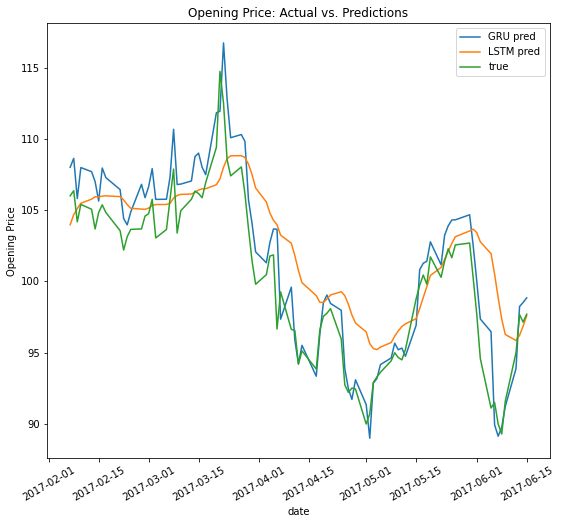

In [108]:
# Visualizations - LSTM & GRU predictions vs. actual values-
plt.figure(figsize = (9, 8))
sns.lineplot(x = data_forecast['Date'], y = data_forecast['Open_GRU_pred'], label = 'GRU pred')
sns.lineplot(x = data_forecast['Date'], y = data_forecast['Open_LSTM_pred'], label = 'LSTM pred')
sns.lineplot(x = data_forecast['Date'], y = data_forecast['Open_actual'], label = 'true')
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("Opening Price")
plt.xticks(rotation = 30)
plt.title("Opening Price: Actual vs. Predictions")
plt.show()

# Similar to visualization above.

In [ ]:
'''
us_buz_day = CustomBusinessDay(calendar = USFederalHolidayCalendar())

# Remember that we can only predict one day in future as our model needs 5 variables
# as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16

# Predict past 15 days
n_days_for_prediction = 15

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods = n_days_for_prediction, freq = us_buz_day).tolist()
'''

In [ ]:
# print(predict_period_dates)